# A Simple Classification Network - Voulgari Eleni - A.M. 17005

## Building a Deep Classification Network, optimised for the dataset CIFAR-10

### Prepare Project

   1. Load libraries
   2. Load dataset

In [1]:
# Load libraries
import numpy as np
import keras
import tensorflow as tf
import pickle as pickle
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image
from IPython.display import display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import backend as K 
import os, sys
import urllib
import tarfile

# inline plotting instead of popping out
%matplotlib inline                        

Using TensorFlow backend.


In [2]:
# Set the seeds to have reproducible results
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Load the Dataset through functions, after creating some useful variables 

In [3]:
# Creating some useful variables
cif_size = 32                                          # CIFAR image size
cif_channels = 3                                       # CIFAR image channels
cif_flat = cif_size * cif_size * cif_channels          # Length of the flattened image
classes = 10                                           # Number of the classes that exists
training_files = 5                                     # Number of training files  
file_size = 10000                                      # Number of images in a file
training_images = training_files * file_size           # Number of all images in training dataset
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

In [4]:
# Function for loading a file of the dataset from the folder where it is downloaded
def load_file(file_name):
    path = os.path.join("/home/mscuser/Documents/cifar-10-batches-py/", file_name)  # Replace with the folder that  
                                                                                    # contains the batch files
    
    print('Loading ' + file_name)
    with open(path, mode='rb') as file:    
        file_data = pickle.load(file)
        
    images = file_data[b'data']
    category = np.array(file_data[b'labels'])
    
    # Reshape the loaded images
    images_reshaped = images.reshape([-1, cif_channels, cif_size, cif_size])    
    
    # Move the dimension of the channels to the end
    images_reshaped = np.rollaxis(images_reshaped, 1, 4)
    
    return images_reshaped, category

In [5]:
# Function for loading all the images and categories of the training batches to arrays
def load_training_files():   
    
    # allocate the arrays for the images and the categories
    images = np.zeros(shape=(50000, 32, 32, 3), dtype=int)
    category = np.zeros(shape=(50000), dtype=int)
    
    first = 0
    # For every batch in the training files, load the data and save them continuously in arrays
    for i in range(training_files):
        batch_img, batch_cat = load_file(file_name="data_batch_" + str(i + 1))
        num_img = len(batch_img)
        last = first + num_img
        images[first:last, :] = batch_img
        category[first:last] = batch_cat
        first = last
        
    return images, np_utils.to_categorical(category, classes), category # Reform the classes into one-hot-encoding

In [6]:
# Function for loading the images and categories of the test file
def load_test_file():
    images, category = load_file(file_name="test_batch")
    
    return images, np_utils.to_categorical(category, classes), category # Reform the classes into one-hot-encoding

In [7]:
# Function for calling all the other functions to fully load the dataset
def load_cifar():
    X_train, Y_train, y_train_cat = load_training_files()
    X_test, Y_test, y_test_cat = load_test_file()
    
    return X_train, Y_train, X_test, Y_test, y_train_cat, y_test_cat

In [8]:
# Loading the dataset
X_train, Y_train, X_test, Y_test, y_train_cat, y_test_cat = load_cifar()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print('y_train_cat shape:', y_train_cat.shape)
print('y_test_cat shape:', y_test_cat.shape)

Loading data_batch_1
Loading data_batch_2
Loading data_batch_3
Loading data_batch_4
Loading data_batch_5
Loading test_batch
('X_train shape:', (50000, 32, 32, 3))
('Y_train shape:', (50000, 10))
('X_test shape:', (10000, 32, 32, 3))
('Y_test shape:', (10000, 10))
('y_train_cat shape:', (50000,))
('y_test_cat shape:', (10000,))


## Data Preprocessing

The preprocessing of the data includes the normalization of the integers that appear as the intensity of the color they represent and the splitting of the training set into the training and the validation set for improving the performance.

In [9]:
# Normalize the inputs to be in a range of 0.0-1.0 instead of 0-255
X_train = X_train.astype('float32')  # Change to floating point values to perform the division
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the training set into training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)

('X_train shape:', (40000, 32, 32, 3))
('X_val shape:', (10000, 32, 32, 3))


In [11]:
# Functions for drawing an image of the dataset or a number of images
def draw_img(i):
    im = X_train[i]
    plt.imshow(im)
    plt.show()

def draw_sample(X, n, rows=4, cols=4, imfile=None, fontsize=12):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = X[n+i].reshape(32,32,3)
        plt.imshow(im, cmap='gnuplot2')
        plt.axis('off')
        plt.subplots_adjust(wspace=0.6, hspace=0.01)
    plt.show()

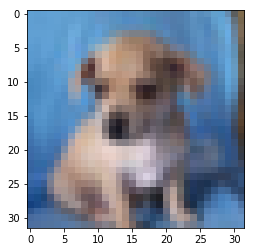

In [12]:
draw_img(10295)

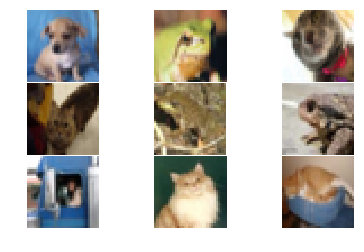

In [13]:
draw_sample(X_train, 10295, 3, 3)

## First Base Model
Create a 8-layer Dense Neural Network as the baseline

In [10]:
# Creating useful variables as the batch size for the NN and the maximum epochs. Also defining when the NN will stop 
# early. Early stopping is stopping the training once your loss starts to increase (accuracy starts to decrease) 
size_batch = 256
max_epochs = 150
stop_early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, mode='auto')

# Function for evaluating the model
def evaluate(model):
    score = model.evaluate(X_test, Y_test)
    print "\n"
    print('Loss: %.3f' % score[0])
    print('Accuracy: %.3f' % score[1])

In [15]:
# Creating a first baseline model with 8-hidden layers of 512 neurons in each layer
baseline = Sequential()
baseline.add(Flatten(input_shape=(cif_size, cif_size, cif_channels))) # Flatten our input into an 1-D array

for i in range(8):
    baseline.add(Dense(512, activation='relu'))  # Create hidden layers

baseline.add(Dense(classes, activation='softmax')) # Create output layer
baseline.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the baseline

%time model_fit = baseline.fit(X_train, Y_train, batch_size=size_batch, epochs=max_epochs, \
                    validation_data=(X_val, Y_val), callbacks=[stop_early], shuffle=True, verbose=0) # Train the baseline
print "\n"
evaluate(baseline)                    # Evaluate the baseline

CPU times: user 18min 52s, sys: 3min 25s, total: 22min 17s
Wall time: 6min 17s


10000/10000 [==============================] - 4s     


Loss: 1.514
Accuracy: 0.474


In [19]:
# Function for predicting the classes of the test batch through the model and show the results
def predict_and_show_results(model):
    
    y_pred = model.predict_classes(X_test)
    print "\n"
    
    true_preds = [(x,y) for (x,y,p) in zip(X_test, y_test_cat, y_pred) if y == p]
    false_preds = [(x,y,p) for (x,y,p) in zip(X_test, y_test_cat, y_pred) if y != p]
    
    print("Number of true predictions: ", len(true_preds))
    print("Number of false predictions:", len(false_preds))
    
    for i,(x,y,p) in enumerate(false_preds[0:10]):
        plt.subplot(3, 5, i+1)
        plt.imshow(x, cmap='gnuplot2')
        plt.title("y: %s\np: %s" % (class_name[y], class_name[p]), fontsize=9, loc='left')
        plt.axis('off')
        plt.subplots_adjust(wspace=0.6, hspace=0.2)

 9920/10000 [============================>.] - ETA: 0s

('Number of true predictions: ', 4737)
('Number of false predictions:', 5263)


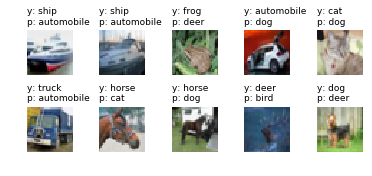

In [17]:
predict_and_show_results(baseline)

In [18]:
# Find the history keys to use for visualization the loss and the accuracy
model_fit.history.keys()[0:2]

['acc', 'loss']

In [16]:
# Function for summarizing and ploting either the history of the accuracy or the history of the loss
def plot_history(model_fit, metric):
    if metric == 'acc':
        plt.plot(model_fit.history['acc'])
        plt.plot(model_fit.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    elif metric == 'loss':
        plt.plot(model_fit.history['loss'])
        plt.plot(model_fit.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

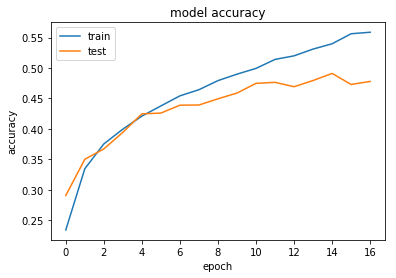

In [20]:
plot_history(model_fit, 'acc')

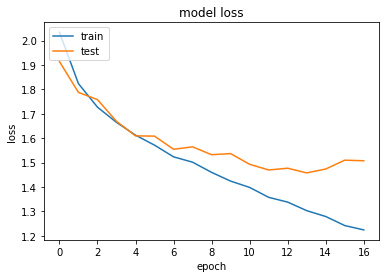

In [21]:
plot_history(model_fit, 'loss')

The NN gives a better result than the random guess (10%) at about 0.49% accuracy. 

However, we observe that the testing loss is much higher than the training loss. 

The model needs to be regularized to have better generalizability.

## Second Base Model - Generalization

To improve the testing performance we can reduce the complexity of the model by using fewer layers and neurons per layer. We choose random number for the above parameters.

In [98]:
baseline2 = Sequential()

baseline2.add(Flatten(input_shape=(cif_size, cif_size, cif_channels))) # Flatten the input into a 1-D array

baseline2.add(Dense(512, activation='relu'))   # Create hidden layers
baseline2.add(Dense(256, activation='relu'))
baseline2.add(Dense(64, activation='relu'))
baseline2.add(Dense(32, activation='relu'))

baseline2.add(Dense(classes, activation='softmax'))  # Create output layer

baseline2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model

%time model2 = baseline2.fit(X_train, Y_train, batch_size=size_batch, epochs=max_epochs, \
                    validation_data=(X_val, Y_val), callbacks=[stop_early], shuffle=True, verbose=0) # Train the model
print "\n"
evaluate(baseline2)  # Evaluate the model

CPU times: user 11min, sys: 2min 5s, total: 13min 6s
Wall time: 4min 3s


10000/10000 [==============================] - 4s     


Loss: 1.432
Accuracy: 0.501


 9952/10000 [============================>.] - ETA: 0s

('Number of true predictions: ', 4956)
('Number of false predictions:', 5044)


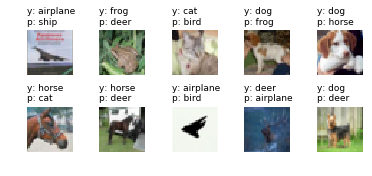

In [99]:
predict_and_show_results(baseline2)

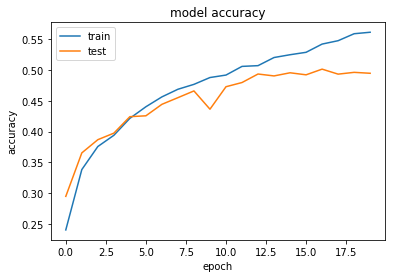

In [100]:
plot_history(model2, 'acc')

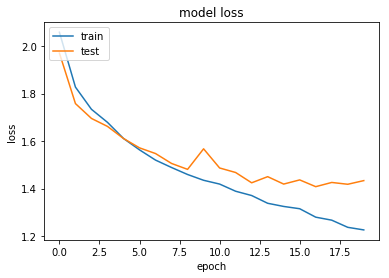

In [101]:
plot_history(model2, 'loss')

As we can see with the random selection there has been some change in the accuracy and in the instances that were predicted correctly. 

We can choose other parameters randomly and do this until we gain better results but this would be time consuming and it could lead to no better performance.

## Third Model - Optimizer and Loss

For the next model we are going to try to use the mean squared error for the loss and the stochastic gradient descent with Nesterov momentum for the optimizer. We also define the learning rate of the SGD to 0.01.

In [108]:
# Creating a first baseline model with 8-hidden layers of 512 neurons in each layer
model3 = Sequential()
model3.add(Flatten(input_shape=(cif_size, cif_size, cif_channels))) # Flatten our input into an 1-D array

for i in range(8):
    model3.add(Dense(512, activation='relu'))  # Create hidden layers

model3.add(Dense(classes, activation='softmax')) # Create output layer

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])  # Compile the model

%time model_fit3 = model3.fit(X_train, Y_train, batch_size=size_batch, epochs=max_epochs, \
                    validation_data=(X_val, Y_val), callbacks=[stop_early], shuffle=True, verbose=0) # Train the model

CPU times: user 1h 2min 32s, sys: 5min 33s, total: 1h 8min 5s
Wall time: 26min 22s


10000/10000 [==============================] - 4s     


Loss: 0.067
Accuracy: 0.461


 9984/10000 [============================>.] - ETA: 0s

('Number of true predictions: ', 4912)
('Number of false predictions:', 5088)


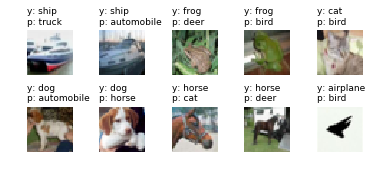

In [119]:
evaluate(model3)
print "\n"
predict_and_show_results(model3)

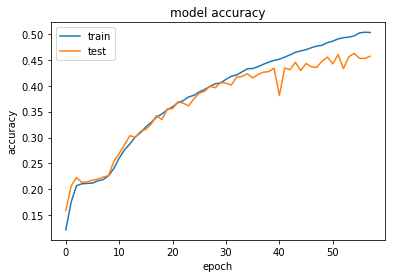

In [113]:
plot_history(model_fit3, 'acc')

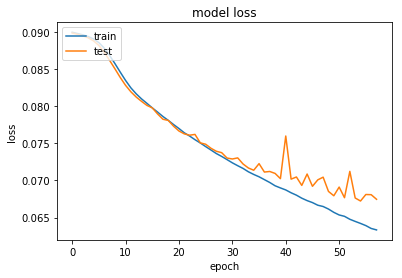

In [114]:
plot_history(model_fit3, 'loss')

As we observe the metrics for the training set of the above model are more smooth but the accuracy was decreased, so our next step is to perform regularization.

## Fourth Model - Regularization

For our fourth model we are using a regularization technique called weight decay and with this method we penalize large weights in the cost function.

In [124]:
l2_alpha = 0.0005

model4 = Sequential()
model4.add(Flatten(input_shape=(cif_size, cif_size, cif_channels))) # Flatten our input into a 1-D array

for i in range(8): 
    model4.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_alpha))) # Create hidden layers

model4.add(Dense(classes, activation='softmax', kernel_regularizer=l2(l2_alpha))) # Create output layer

# compile model
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model
# training & evaluatation

%time model_fit4 = model4.fit(X_train, Y_train, batch_size=size_batch, epochs=max_epochs, \
                    validation_data=(X_val, Y_val), callbacks=[stop_early], shuffle=True, verbose=0) # Train the model

CPU times: user 24min 35s, sys: 3min 3s, total: 27min 39s
Wall time: 7min 35s


In [126]:
evaluate(model4)

 9920/10000 [============================>.] - ETA: 0s

Loss: 1.617
Accuracy: 0.462


Regularization made no difference to the accuracy of the model.

## Fifth Model - Dropout

When processing a batch in training, we can randomly drop some units from the NN and this is called dropout. This is a way to force each neuron to rely more on its own and not on the other neurons.

In [130]:
drop_rate = 0.2

model5 = Sequential()
model5.add(Flatten(input_shape=(cif_size, cif_size, cif_channels))) # Flatten our input into a 1-D array

for i in range(8): 
    model5.add(Dense(512))                 # Create hidden layers
    model5.add(Activation('relu'))
    model5.add(Dropout(drop_rate))         # Randomly dropout neurons

model5.add(Dense(classes, activation='softmax')) # Create output layer

model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model

%time model_fit5 = model5.fit(X_train, Y_train, batch_size=size_batch, epochs=max_epochs, \
                    validation_data=(X_val, Y_val), callbacks=[stop_early], shuffle=True, verbose=0) # Train the model

CPU times: user 23min 45s, sys: 3min 14s, total: 27min
Wall time: 7min 43s


In [131]:
evaluate(model5)

 9952/10000 [============================>.] - ETA: 0s

Loss: 1.712
Accuracy: 0.376


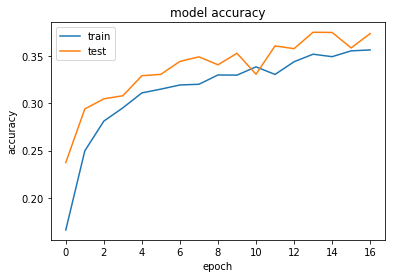

In [132]:
plot_history(model_fit5, 'acc')

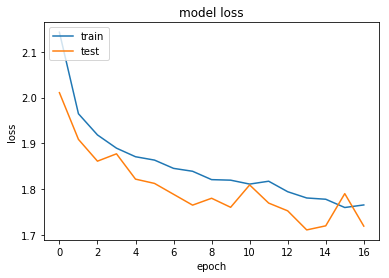

In [133]:
plot_history(model_fit5, 'loss')

The dropout method caused the accuracy of this NN to a significant drop but we also notice underfitting in this model. The dropout network might require more epochs to train.

## Sixth Model - Data Augmentation

NNs are known to need a lot of data to be able to train well. We can perform data augmentation and train the model again with "more" instances.  This is done by "augmenting" each instance by random transformations, without changing its class label. With data augmentation, a model learns from more instances. This prevents overfitting when the data are of limited size.

('Number of images returned by iterator:', 15)


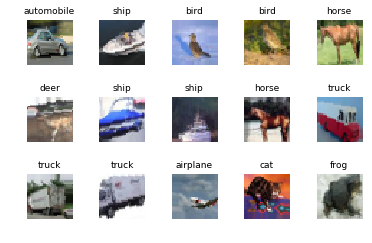

In [12]:
imgen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False, 
    shear_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Fit and visualize the "new" made images
imgen.fit(X_train)
it = imgen.flow(X_train, Y_train, batch_size=15) # This is a Python iterator
images, categories = it.next()
print("Number of images returned by iterator:", len(images))
for i in range(15):
    plt.subplot(3, 5, i+1)
    im = images[i]
    c = np.where(categories[i] == 1)[0][0] # convert one-hot to regular index
    plt.imshow(im, cmap='gnuplot2')
    plt.title(class_name[c], fontsize=9)
    plt.axis('off')
    plt.subplots_adjust(wspace=0.6, hspace=0.2)

In [163]:
model6 = Sequential()

model6.add(Flatten(input_shape=(cif_size, cif_size, cif_channels))) # flatten our input into an 1-D array

for i in range(8):
    model6.add(Dense(512, activation='relu'))  # Create hidden layers

model6.add(Dense(classes, activation='softmax'))  # Create output layer

model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model

%time model_fit6 = model6.fit_generator( \
                     imgen.flow(X_train, Y_train, batch_size=size_batch), \
                     samples_per_epoch=X_train.shape[0], \
                     nb_epoch=max_epochs, \
                     validation_data=(X_val, Y_val), \
                     callbacks=[stop_early], \
                     verbose=0)   # Train the model

/home/mscuser/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/home/mscuser/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., verbose=0, validation_data=(array([[[..., steps_per_epoch=156, epochs=150, callbacks=[<keras.ca...)`
  """Entry point for launching an IPython kernel.


CPU times: user 41min 23s, sys: 2min 18s, total: 43min 42s
Wall time: 20min 21s


In [164]:
evaluate(model6)

 9952/10000 [============================>.] - ETA: 0s

Loss: 1.429
Accuracy: 0.485


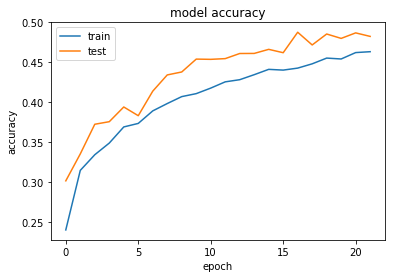

In [165]:
plot_history(model_fit6, 'acc')

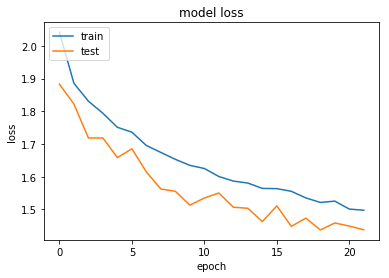

In [166]:
plot_history(model_fit6, 'loss')

As we can observe the data augmentation technique slightly improved the accuracy of the first model, but we also notice underfitting. 

## Seventh Model - More neurons per layer

To avoid the underfitting problem we can try increasing the number of the neurons each hidden layer has.

In [167]:
model7 = Sequential()

model7.add(Flatten(input_shape=(cif_size, cif_size, cif_channels))) # flatten our input into an 1-D array

for i in range(8):
    model7.add(Dense(1024, activation='relu'))  # Create hidden layers

model7.add(Dense(classes, activation='softmax'))  # Create output layer

model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model

%time model_fit7 = model7.fit_generator( \
                     imgen.flow(X_train, Y_train, batch_size=size_batch), \
                     samples_per_epoch=X_train.shape[0], \
                     nb_epoch=max_epochs, \
                     validation_data=(X_val, Y_val), \
                     callbacks=[stop_early], \
                     verbose=0)

/home/mscuser/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/home/mscuser/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., verbose=0, validation_data=(array([[[..., steps_per_epoch=156, epochs=150, callbacks=[<keras.ca...)`
  """Entry point for launching an IPython kernel.


CPU times: user 1h 55min 20s, sys: 6min 21s, total: 2h 1min 42s
Wall time: 31min 54s


In [168]:
evaluate(model7)

 9984/10000 [============================>.] - ETA: 0s

Loss: 1.462
Accuracy: 0.476


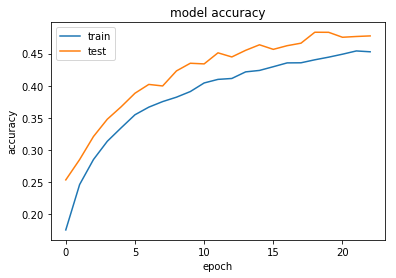

In [169]:
plot_history(model_fit7, 'acc')

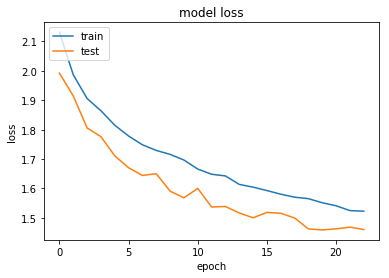

In [170]:
plot_history(model_fit7, 'loss')

The underfitting problem doesn't seem to get fixed.

## Eighth Model - Increase Batch size with best model

So, for this model we decided to take the model that produced the best accuracy and only change the batch size to 1024. 

In [175]:
model8 = Sequential()

model8.add(Flatten(input_shape=(cif_size, cif_size, cif_channels))) # flatten our input into an 1-D array

model8.add(Dense(128, activation='relu'))   # Create hidden layers
model8.add(Dense(64, activation='relu')) 
model8.add(Dense(32, activation='relu'))
model8.add(Dense(16, activation='relu'))

model8.add(Dense(classes, activation='softmax'))  # Create output layer

model8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model

%time model_fit8 = model8.fit_generator( \
                     imgen.flow(X_train, Y_train, batch_size=1024), \
                     samples_per_epoch=X_train.shape[0], \
                     nb_epoch=max_epochs, \
                     validation_data=(X_val, Y_val), \
                     callbacks=[stop_early], \
                     verbose=0)

/home/mscuser/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/home/mscuser/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., verbose=0, validation_data=(array([[[..., steps_per_epoch=39, epochs=150, callbacks=[<keras.ca...)`
  """Entry point for launching an IPython kernel.


CPU times: user 34min 27s, sys: 9.04 s, total: 34min 36s
Wall time: 31min 18s


In [176]:
evaluate(model8)

 9760/10000 [============================>.] - ETA: 0s

Loss: 1.513
Accuracy: 0.462


The performance dropped in this case and needs to be further be tuned.

## Ninth Model - Last try

For our last try, we used the 4 hidden layers with decreasing number of neurons in each layer. We also used the dropout method but not for he first layer and with increasing rate for each of the next two layers. Batch size was reduced to 128 and epochs were reduced to 40 without the callback for early stopping of the network.  

In [13]:
model9 = Sequential()

model9.add(Flatten(input_shape=(cif_size, cif_size, cif_channels))) # flatten our input into an 1-D array

model9.add(Dense(128, activation='relu'))   # Create hidden layers
model9.add(Dense(64, activation='relu'))
model9.add(Dropout(0,1)) 
model9.add(Dense(32, activation='relu'))
model9.add(Dropout(0,2)) 
model9.add(Dense(16, activation='relu'))

model9.add(Dense(classes, activation='softmax'))  # Create output layer

model9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model

%time model_fit9 = model9.fit_generator( \
                     imgen.flow(X_train, Y_train, batch_size=128), \
                     samples_per_epoch=X_train.shape[0], \
                     nb_epoch=40, \
                     validation_data=(X_val, Y_val), \
                     verbose=0)

/home/mscuser/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/home/mscuser/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., verbose=0, validation_data=(array([[[..., steps_per_epoch=312, epochs=40)`
  """Entry point for launching an IPython kernel.


CPU times: user 40min 56s, sys: 1min 20s, total: 42min 16s
Wall time: 34min 50s


In [14]:
evaluate(model9)

 9696/10000 [============================>.] - ETA: 0s

Loss: 1.406
Accuracy: 0.504


 9696/10000 [============================>.] - ETA: 0s

('Number of true predictions: ', 5037)
('Number of false predictions:', 4963)


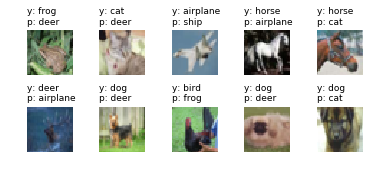

In [20]:
predict_and_show_results(model9)

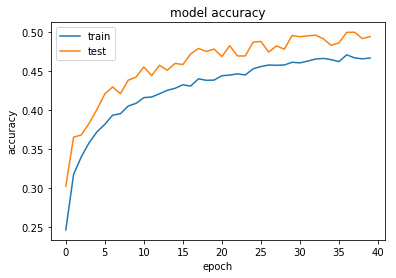

In [22]:
plot_history(model_fit9, 'acc')

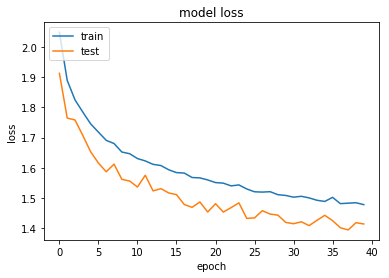

In [23]:
plot_history(model_fit9, 'loss')

As we can see this model is the best so far and this might be because of the batch size or the fact that we did not use early stopping. The problem of underfitting is still here. We could further create another one with more epochs to run and see if it is improving any further.